# Project CEGM2003

## Import modules and packages

In [1]:
import numpy as np
import sys
sys.path.append('../pyJive/')
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import numpy.random as rnd
from utils import proputils as pu
import main
from names import GlobNames as gn

%matplotlib widget

## Loss function

In [44]:
def get_geom_file(y_list): 
    
    file = open('bridge.geom')
    filestring = file.read()

    split = filestring.split('\n')

    y_list = np.append(y_list, y_list[:-1][::-1])
    mod_indices = np.arange(3,20,2)

    count = 0
    for i in range(len(split)):
        split[i] += '\n'
        if i in mod_indices:
            linesplit = split[i].split(' ')
            linesplit[-1] = str(y_list[count]) + '\n'
            split[i] = ' '.join(linesplit)
            count += 1

    geom = ' '.join(split)

    with open("geomfile.geom", "w") as file:
        file.write(geom)
        
    return file.name

def eigenfrequencies(A_list, y_list):

    # Read the input file and store in props object
    props = pu.parse_file('bridge_frequency.pro')
    props['model']['truss']['area'] = A_list
    props['init']['mesh']['file'] = get_geom_file(y_list)
    
    
    # Call the program and store output in globdat
    globdat = main.jive(props)

    # Write additional output
    return(globdat[gn.EIGENFREQS][0:3]/2/np.pi)

def constraint(A_list, y_list, constr1=20, constr2=40, constr3=60):
    
    

    # convert first three natrual frequencies to Hz
    freq1, freq2, freq3 = eigenfrequencies(A_list, y_list)
    

    # calculate the violations of the constraints
    violation1 = max(0, constr1 - freq1)
    violation2 = max(0, constr2 - freq2)
    violation3 = max(0, constr3 - freq3)
    
    #calculate the losses with the penalty
    total_violation = violation1 + violation2 + violation3
    return total_violation

def mass_TRUSS(Areas, y_list, density=7800):
    
    x_coordinates=[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10]
    y_coordinates = [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
    y_coordinates[2] = y_list[0]
    y_coordinates[4] = y_list[1]
    y_coordinates[6] = y_list[2]
    y_coordinates[8] = y_list[3]
    y_coordinates[10] = y_list[4]
    y_coordinates[12] = y_list[3]
    y_coordinates[14] = y_list[2]
    y_coordinates[16] = y_list[1]
    y_coordinates[18] = y_list[0]
    
    #Calculate the lengths of the different elements
    Lengths = np.zeros(len(Areas))
    Lengths[0] = 1
    Lengths[1] = np.sqrt(x_coordinates[2]**2 + y_coordinates[2]**2)
    Lengths[2] = y_coordinates[2]
    Lengths[3] = np.sqrt((x_coordinates[2]-x_coordinates[3])**2 + (y_coordinates[2]-y_coordinates[3])**2)
    Lengths[4] = np.sqrt(1 + (y_coordinates[2]-y_coordinates[4])**2)
    Lengths[5] = y_coordinates[4]
    Lengths[6] = np.sqrt((x_coordinates[4]-x_coordinates[5])**2 + (y_coordinates[4]-y_coordinates[5])**2)
    Lengths[7] = np.sqrt(1 + (y_coordinates[4]-y_coordinates[6])**2)
    Lengths[8] = y_coordinates[6]
    Lengths[9] = np.sqrt((x_coordinates[6]-x_coordinates[7])**2 + (y_coordinates[6]-y_coordinates[7])**2)
    Lengths[10] = np.sqrt(1 + (y_coordinates[6]-y_coordinates[8])**2)
    Lengths[11] = y_coordinates[8]
    Lengths[12] = np.sqrt((x_coordinates[8]-x_coordinates[9])**2 + (y_coordinates[8]-y_coordinates[9])**2)
    Lengths[13] = np.sqrt(1 + (y_coordinates[8]-y_coordinates[10])**2)
    Lengths[14] = y_coordinates[10]
    
    #Calculate the volumes of the elements
    Volumes = Lengths * Areas
    
    #Calculate the total volume by summing the elements
    Total_Volume = 10*Volumes[0] + 2*(Volumes[1] + Volumes[2] + Volumes[3] + Volumes[4] + Volumes[5] + Volumes[6] + Volumes[7] + Volumes[9] + Volumes[10] + Volumes[11] + Volumes[12] + Volumes[13]) + Volumes[14]
    
    #Calculate the total mass
    Mass = Total_Volume * density
    
    return Mass

In [45]:
def loss_function(A_list, y_list, mass_penalty=1, constraint_penalty=1000000):
    total_loss = (constraint_penalty * constraint(A_list, y_list)) + (mass_penalty * mass_TRUSS(A_list, y_list))
    if constraint(A_list, y_list) != 0:
        print(f'The constraints for the natural frequencies are not met')
    else:
        print(f'The constraints of the natural frequencies are met')
        
    return print(f'The total loss is:{total_loss}')

#### Test loss function

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file geomfile.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  1.2608e+02 rad / s


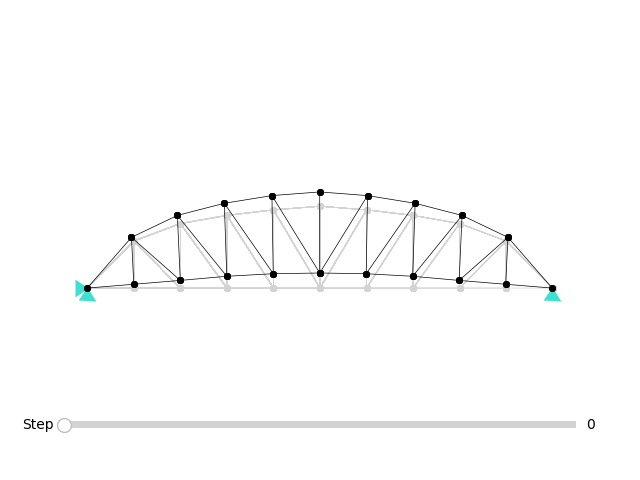

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file geomfile.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  1.2608e+02 rad / s


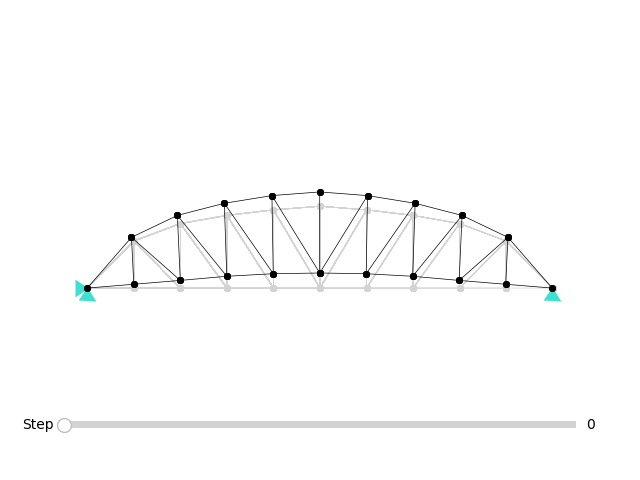

End of execution
The constraints of the natural frequencies are met
The total loss is:356.6388578444165


In [50]:
import numpy.random as rnd

mx = 0.008
A_list_init = 0.005 * np.ones(15)
y_list_init = [1,1,1,1,1]
A_list_random = mx * (rnd.random_sample(size=15))         #length must be 15
y_list_random = np.arange(1,6,1)

A_list_kanarachos = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]

y_list_kanarachos = [1.0108, 1.3860, 1.5608, 1.6802, 1.7580]

# loss_init = loss_function(A_list_init, y_list_init)
# loss = loss_function(A_list_random, y_list_random)
loss_karnacharos= loss_function(A_list_kanarachos, y_list_kanarachos)

## BayesianOptimizer

## Run optimizer

## Visualize Results